# HarvestStat Data Profiling - Zambia

In [1]:
import glob, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Load FEWS NET administrative boundaries ------- #
epsg = 'EPSG:32735' # Zambia
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/ZM_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
parameters = {
    'format': 'json',
    'country': 'Zambia',
    'product':['R011','R012','R013','R014','R015','R016','R017','R018'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1980	 | ZM1980A1 | 9	| ZM1980A2	| 57	| nan	| 0	|
| 1990	 | ZM1990A1 | 9	| nan	| 0	| nan	| 0	|
| 1998	 | nan | 0	| ZM1998A2	| 72	| nan	| 0	|
| 2011	 | ZM2011A1 | 10	| ZM2011A2	| 74	| nan	| 0	|
| 2012	 | ZM2012A1 | 10	| ZM2012A2	| 89	| nan	| 0	|
----------------------------------------------- #


In [3]:
# Manual Pre-processing before Sweeping --------- #
#1)Zambia admin 2 uses a 1998 FNID while all others use 1980 FNID in some early 90s pre-1998 years (district exists both pre- and post- 1998)
df['fnid'][(df.fnid=='ZM1998A21212')&(df.season_date.str[:4].astype(int)<1998)] ='ZM1980A21208'#fix ZM FNID in the pre-1998 years
#2) Zambia has three different names for maize, two refer to the same crop and the third is marginal and should be removed
df = df[~(df['product']=='Maize Grain (Yellow)')] #drop the Maize Grain (Yellow) obs, which are only present in 1-2 admins for 2 years
df.loc[(df['product']=='Maize Grain (White)'),'product'] = 'Maize (Corn)' #rename complementary product names to be the same

# 3. Default setting 
# a.1) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# a.2) Early in the record the catch-all crop production system is 'all' rather than none. Make these to none-type
df.loc[df['crop_production_system'] == 'all', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'

#4. Manual setting
# a) population groups within admin units
# Zambia has a number of admin 2 units with population groups that split the admin into two, 
# (e.g. ~Lusaka Rural East~ and ~Lusaka Rural West~). These two groups need to be recombined to map because
# there is no regional shapefile definition for these sub-admin units (for some countries there is)
#
# Calculate the sum of production, harvested area and planted area, then recalculate yield for these admin units
rows = ['fnid','season_year', 'product','indicator','crop_production_system','value','population_group']
#find duplicates then aggregate to fnid after pivoting around the indicator
dupes = df[rows[:-1]][df[rows[:-2]].duplicated(keep=False)]
#create a df that has one value per duplicated value
toFill = df[df[['fnid','season_year','indicator','crop_production_system','product']].duplicated(keep=False)]# find all duplicates
toFill = toFill[~toFill[['fnid','season_year','indicator','crop_production_system','product']].duplicated(keep='first')]# keep only one
dupes = dupes.groupby(by=['fnid','season_year','indicator','crop_production_system','product']).sum()
dupes.reset_index(inplace=True)
d_ha = dupes.copy(deep=True)
d_pa = dupes.copy(deep=True)
d_ha['value'].loc[dupes.indicator=='Yield'] = d_ha['value'].loc[d_ha.indicator=='Quantity Produced'].values/\
                                               d_ha['value'].loc[d_ha.indicator=='Area Harvested'].values
#if calculated yield is nan (meaning HA = 0), recalculate w/ planted area
d_pa['value'].loc[dupes.indicator=='Yield'] = d_pa['value'].loc[d_pa.indicator=='Quantity Produced'].values/\
                                               d_pa['value'].loc[d_pa.indicator=='Area Planted'].values
#For Zambia the planted area seems to be more reliable, so let's use planted area consistently rather than harvested area
dupes['value'].loc[dupes.indicator=='Yield'] = d_pa['value'].loc[dupes.indicator=='Yield']
#find where calculated yield is nan when calculated with PA and use HA instead
dupes['value'].loc[(dupes.indicator=='Yield')&(~np.isfinite(dupes.value))] = \
      d_ha['value'].loc[(dupes.indicator=='Yield')&(~np.isfinite(dupes.value))]
#set 0 back to nan
dupes['value'].loc[dupes.value==0]=np.nan
#merge the new values back into the placeholder DF
toFill = toFill.drop(['value'],axis=1)
toFill = toFill.merge(dupes, how='left',on = ['fnid','season_year','indicator','crop_production_system','product'])
#drop all duplicate obs from original DF and append the filled DF
df = df[~df[['fnid','season_year','indicator','crop_production_system','product']].duplicated(keep=False)]
df = df.append(toFill)
#becasue the population groups have been recombined, set them all equal to 'none'
df['population_group'] = 'none'

#5) limit to areas with collected data
df = df[df['status'] == 'Collected']

#6) Rename the unspecified variety of Millet to be the same crop as Millet (Finger) in 2011, 
#then drop the 2015 and 2016 obs b/c they're not the same crop
df = df[~((df['product']=='Millet (Finger)')&
              ((df.season_year=='Annual 2015')|(df.season_year=='Annual 2016')))]
df['product'][df['product']=='Millet (Finger)'] = 'Millet'

#7) remove a couple of incorrect values (off by multiple orders of magnitude) that couldn't be corrected
df['value'][(df['product']=='Sorghum')&(df.fnid=='ZM1998A20908')&(df.season_year=='Annual 2001')]=np.nan
df['value'][(df['product']=='Sorghum')&(df.fnid=='ZM1998A21207')&(df.season_year=='Annual 1998')]=np.nan

#8) fix two values, which are off by an order of magnitude according to the recorded yield value
df['value'][(df['indicator']=='Area Harvested')&(df['product']=='Rice (Paddy)')
   &(df.fnid=='ZM1998A20410')&(df.season_year=='Annual 2008')] = 40

df['value'][(df['indicator']=='Yield')&(df['product']=='Barley (Unspecified)')&
            (df.fnid=='ZM2011A20902')&(df.season_year=='Annual 2016')] = 4.108 #off by an order of magnitude

df['value'][(df['indicator']=='Quantity Produced')&(df['product']=='Barley (Unspecified)')&
            (df.fnid=='ZM2011A20902')&(df.season_year=='Annual 2016')] = 539.175 #off by an order of magnitude


# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df,area_priority='Area Planted')
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([ZM_Admin2_1980,ZM_Admin2_1998,ZM_Admin2_2011], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

/var/folders/pk/_ym78shs7tx06w00zbcwxwgc0000gp/T/ipykernel_80471/558933814.py:35: RuntimeWarning: divide by zero encountered in true_divide
  d_ha['value'].loc[dupes.indicator=='Yield'] = d_ha['value'].loc[d_ha.indicator=='Quantity Produced'].values/\


- Remove missing records ---------------------- #
Orignial data points: 48,308
Removed 876 "Missing Value" points
9,494/9,606 "Area Harvested" points are retained.
12,893/12,984 "Area Planted" points are retained.
12,524/12,859 "Quantity Produced" points are retained.
12,521/12,859 "Yield" points are retained.
Current data points: 47,432

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1980 - 2017
19 grain types are found: Bambara groundnut, Barley (Unspecified), Beans (mixed), Cassava, Coffee (unspecified), Cottonseed (Other), Cowpeas (Mixed), Maize (Corn), Millet, Pineapple (unspecified), Potato (Irish), Rice (Paddy), Sorghum, Soybean (unspecified), Sugarcane (for sugar), Sunflower seed, Sweet Potatoes, Velvet bean, Wheat Grain
1 seasons are found: Annual (04-01)
1 crop production system are found: none
Data sources include:
[1] Ministry of Agriculture and The Central Statistics Office, Zambia --- Crop Forecast Survey 

- Zambia crop seasonal calendar

<img src="https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-zambia.png?itok=UxZI1czA" width=900><br>

<img src="https://ipad.fas.usda.gov/rssiws/al/crop_calendar/images/safrica_za_calendar.png" width=900>

- comparison of boundaries

<img src="../figures/ZM_admin_shapes.png" width=900>

- In Zambia, basd on the FEWS NET data, there were four times of changes in administrative units: 1980, 1998, 2011, and 2012.

| year	 | Admin1   | # units   | Admin2   | # units   |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 1980	 | ZM1980A1 | 9	| ZM1980A2	| 57	|
| 1990	 | ZM1990A1 | 9	| nan	| 0	|
| 1998	 | nan | 0	| ZM1998A2	| 72	|
| 2011	 | ZM2011A1 | 10	| ZM2011A2	| 74	|
| 2012	 | ZM2012A1 | 10	| ZM2012A2	| 89	|


- Here, we use **`ZM2011A2`** to represent all admin-level 2 crop data because although there is a 2012 file, this doesn't appear to be used (e.g. no corresponding FNIDs)
- The data is all reported as `Annual` for the season
- Original data have both 'none' and 'all' as production systems, but these are essentially the same, indicating a default produciton system so they have all been changed to 'none' types.

In [4]:
# Define the latest shapefile ------------------- #
shape_latest = ZM_Admin2_2011.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

In [5]:
# Link admin boundaries ------------------------- #
link_1998, over_1998 = FDW_PD_CreateAdminLink(ZM_Admin2_1998, ZM_Admin2_2011, 'ADMIN2', 'ADMIN2', prod, epsg)
link_1980, over_1980 = FDW_PD_CreateAdminLink(ZM_Admin2_1980, ZM_Admin2_2011, 'ADMIN2', 'ADMIN2', prod, epsg)
# Crop specific ratios
link_ratio_1998 = FDW_PD_RatioAdminLink(link_1998, prod, over_1998, mdx_pss)
link_ratio_1980 = FDW_PD_RatioAdminLink(link_1980, prod, over_1980, mdx_pss)

# Merge link_ratio
assert link_ratio_1998.keys() == link_ratio_1980.keys()
link_merged = [link_ratio_1980, link_ratio_1998]
fnids_new = list(link_merged[0].keys())
link_ratio = dict()
for fnid in fnids_new:
    container = []
    for link in link_merged:
        container.append(link[fnid])
    link_ratio[fnid] = pd.concat(container, axis=1)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #

In [6]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Manual change of product name
product_category_custom = {
    'Bambara groundnut': 'Bambara groundnut',
    'Barley (Unspecified)': 'Barley',
    'Beans (mixed)': 'Beans (mixed)',
    'Cassava': 'Cassava',
    'Coffee (unspecified)': 'Coffee',
    'Cottonseed (Other)': 'Cottonseed',
    'Cowpeas (Mixed)': 'Cowpeas',
    'Maize (Corn)': 'Maize',
    'Millet': 'Millet',
    'Pineapple (unspecified)': 'Pineapple',
    'Potato (Irish)': 'Potato',
    'Rice (Paddy)': 'Rice',
    'Sorghum': 'Sorghum',
    'Soybean (unspecified)': 'Soybean',
    'Sugarcane (for sugar)': 'Sugarcane',
    'Sunflower seed': 'Sunflower seed',
    'Sweet Potatoes': 'Sweet Potatoes',
    'Velvet bean': 'Velvet bean',
    'Wheat Grain': 'Wheat'
}
assert set(stack['product'].unique()) == set(product_category_custom.keys())
stack['product'] = stack['product'].replace(product_category_custom)
for f, r in link_ratio.items():
    mdx = pd.MultiIndex.from_frame(r.index.to_frame().reset_index(drop=True).replace(product_category_custom))
    r.index = mdx
    link_ratio[f] = r
# Calibration of crop calendar using External Crop Calendar (ECC)
ecc = pd.read_csv('../data/crop_calendar/external_crop_calendar.csv')
ecc = ecc[ecc['country'] == 'Zambia']
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, ecc, link_ratio)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

All [season_name, product, crop_production_system] are in the external crop calendar.


## Postprocessing outlier removal

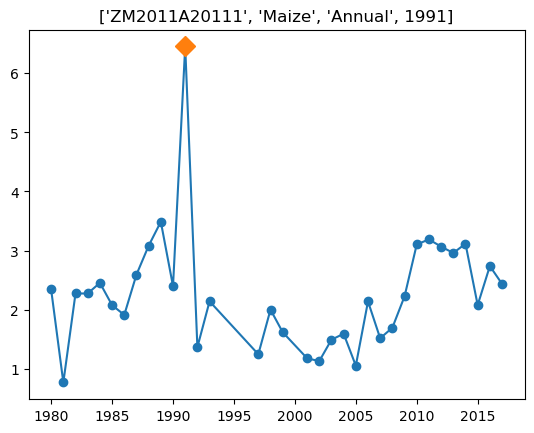

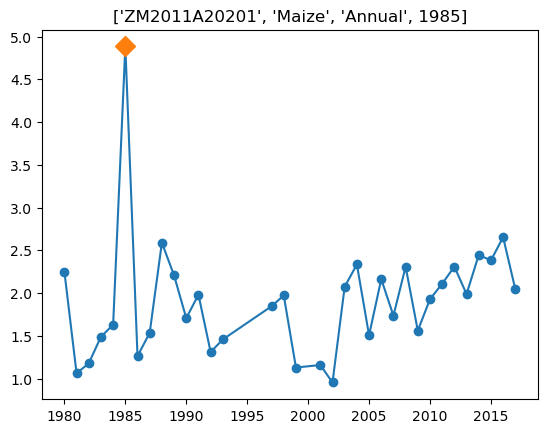

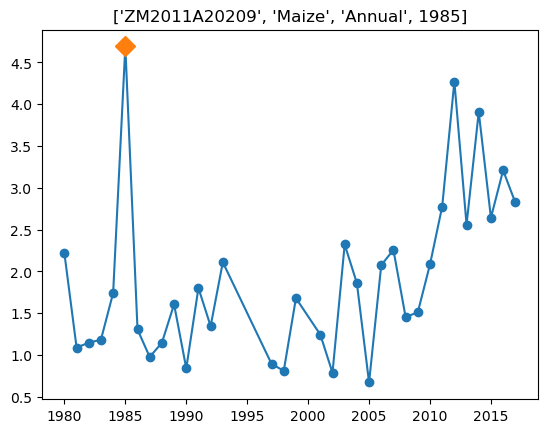

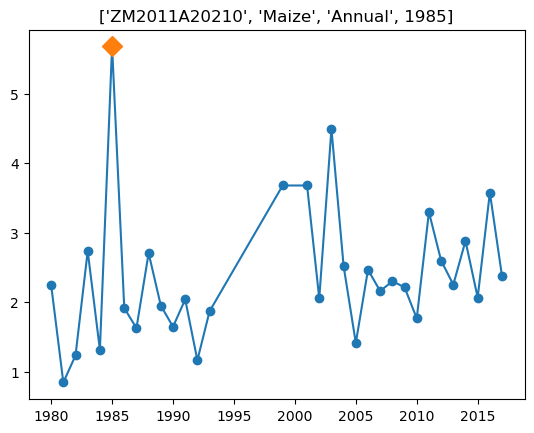

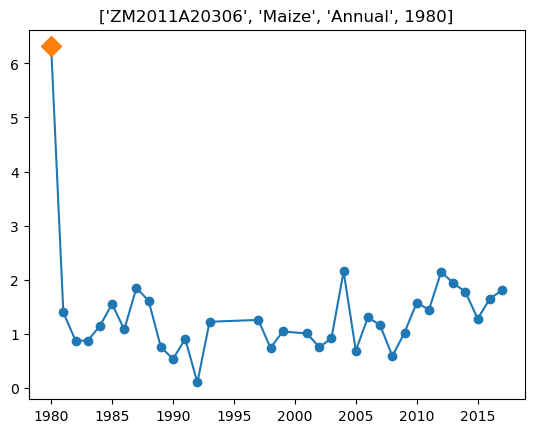

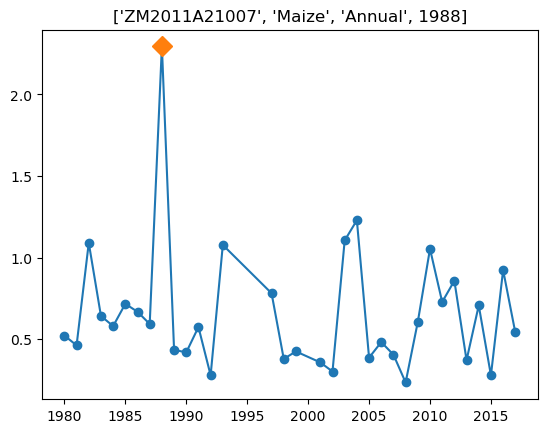

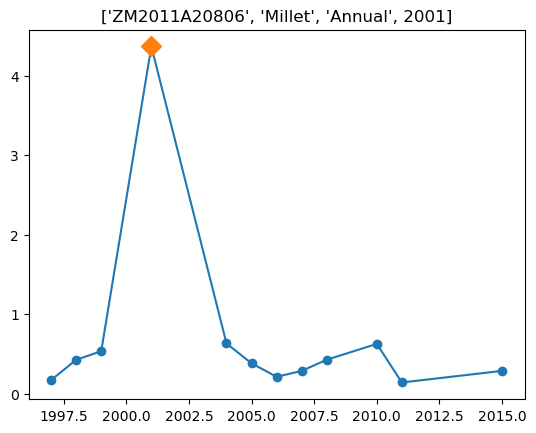

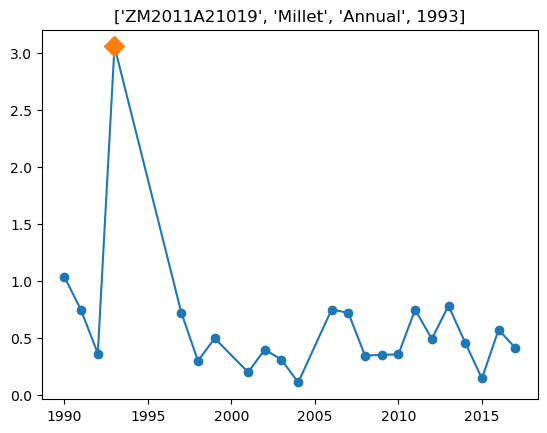

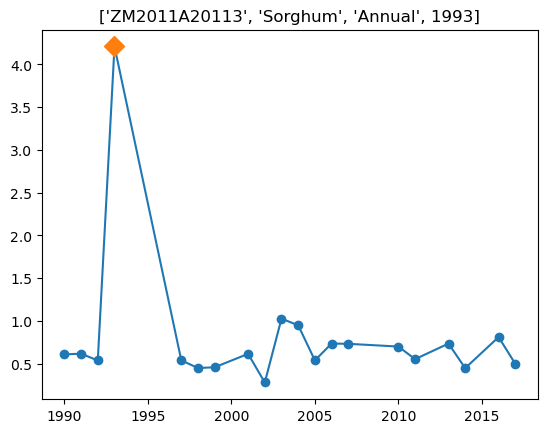

In [7]:
from matplotlib import pyplot as plt
outliers = [['ZM2011A20111','Maize','Annual',1991],
            ['ZM2011A20201','Maize','Annual',1985],
            ['ZM2011A20209','Maize','Annual',1985],
            ['ZM2011A20210','Maize','Annual',1985],
            ['ZM2011A20306','Maize','Annual',1980],
            ['ZM2011A21007','Maize','Annual',1988],
            ['ZM2011A20806','Millet','Annual',2001],
            ['ZM2011A21019','Millet','Annual',1993],
            ['ZM2011A20113','Sorghum','Annual',1993]
           ]
stack=stack.sort_values(by='harvest_year')

#first plot, then remove the values (yield, production and harvested area)
for iou in outliers:
    plt.figure()
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].value.values,'-o')
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].value.values,'D',markersize=10)
    plt.title(str(iou))
    stack.loc[((stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.harvest_year==iou[3])),'QC_flag']=1   
    

In [8]:
# Save data
fn_out = '../data/crop/adm_crop_production_ZM.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')
save_npz('../data/crop/adm_crop_production_ZM_ratio.npz', link_ratio)

../data/crop/adm_crop_production_ZM.csv is saved.
../data/crop/adm_crop_production_ZM_ratio.npz is saved.


# Visualization of production data

/Users/wanders7/Documents/Code/Project/NASA_GSCD/gscd/notebook/tools_graphic.py:433: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


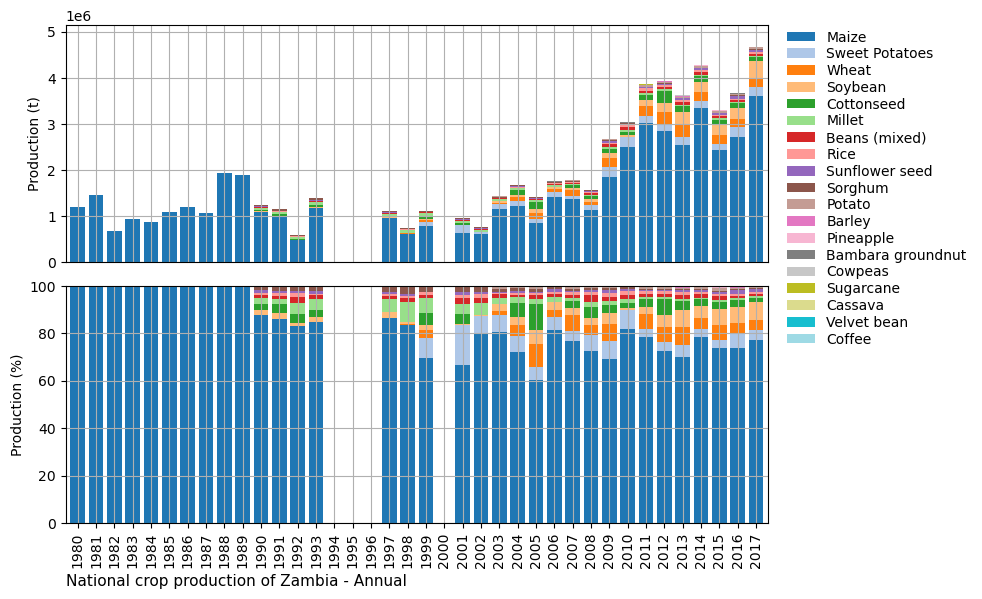

../figures/ZM_bar_natgrainprod_Annual.png is saved.


In [9]:
# Bar chart of national crop production
country_iso, country_name = 'ZM', 'Zambia'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Annual']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

TypeError: pointplot() got an unexpected keyword argument 'linewidth'

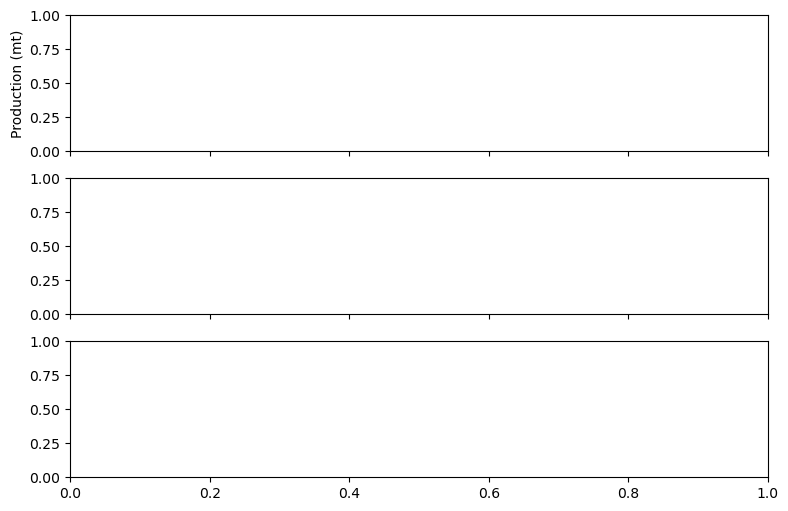

In [10]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'ZM', 'Zambia'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Maize', 'Annual'],
    ['Millet', 'Annual'],
    ['Wheat', 'Annual'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)